# How many points will Stephen Curry get?

In [1]:
library(DBI)
library(RPostgres)

In [2]:
dsn_database = "curry" 
dsn_hostname = "localhost"  
dsn_port = "5432"
dsn_uid = "postgres"
dsn_pwd = "friendlyfire510!"

In [3]:
tryCatch({
    print("Connecting to Database…")
    con <- dbConnect(RPostgres::Postgres(),dbname = dsn_database, 
                 host = dsn_hostname,
                 port = 5432,
                 user = dsn_uid,
                 password = dsn_pwd)
    print("Database Connected!")
    },
    error=function(cond) {
            print("Unable to connect to Database.")
    })

[1] "Connecting to Database…"
[1] "Database Connected!"


In [4]:
tables <- dbListTables(con)
tables

[1] "season_2020" "season_2021" "season_2022" "season_2009" "season_2010"
 [6] "season_2011" "season_2012" "season_2013" "season_2014" "season_2015"
[11] "season_2016" "season_2017" "season_2018" "season_2019"

In [5]:
dbReadTable(con, 'season_2019')

index,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
<int64>,<chr>,<int64>,<chr>,<chr>,<chr>,<chr>,<int64>,<int64>,<int64>,...,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>
0,22019,201939,0021900929,"MAR 05, 2020",GSW vs. TOR,L,27,6,16,...,6,6,7,0,0,1,1,23,-13,1
1,22019,201939,0021900065,"OCT 30, 2019",GSW vs. PHX,L,21,3,11,...,5,5,6,1,2,4,2,9,-13,2
2,22019,201939,0021900047,"OCT 28, 2019",GSW @ NOP,W,31,9,17,...,2,3,11,3,0,1,5,26,32,1
3,22019,201939,0021900036,"OCT 27, 2019",GSW @ OKC,L,30,7,18,...,6,8,5,0,0,2,0,23,-30,1
4,22019,201939,0021900016,"OCT 24, 2019",GSW vs. LAC,L,30,8,20,...,3,4,4,1,0,8,3,23,-19,1


### Obtaining the Tables
We will be using the available games, thus we would need to union all the tables and set it as a dataframe.

In [85]:
query <- ''
for (x in tables){
    query <- paste(query, 'SELECT "MIN", "FGA", "FTA", "REB", "AST", "STL", "PTS" FROM', x)
    if (x != tail(tables, 1)){
        query <- paste(query, 'UNION ALL')
    }
}

In [86]:
all_games <- dbGetQuery(con, query)
all_games$MIN <- as.integer(all_games$MIN)
all_games$FGA <- as.integer(all_games$FGA)
all_games$FTA <- as.integer(all_games$FTA)
all_games$REB <- as.integer(all_games$REB)
all_games$AST <- as.integer(all_games$AST)
all_games$STL <- as.integer(all_games$STL)
all_games$PTS <- as.integer(all_games$PTS)

In [87]:
head(all_games)

,MIN,FGA,FTA,REB,AST,STL,PTS
,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,40,36,6,7,9,1,46
2,37,22,6,3,6,1,21
3,37,25,12,4,6,2,36
4,29,26,10,5,2,1,49
5,31,21,7,4,7,1,34
6,37,31,3,9,2,3,37


### Creating the Model
We will be creating a linear regression model using the dataframe with all available games.

In [149]:
set.seed(2)
library(caTools)

In [150]:
split <- sample.split(all_games, SplitRatio=0.7)

In [151]:
split

[1]  TRUE FALSE  TRUE  TRUE FALSE FALSE  TRUE

In [152]:
train <- subset(all_games, split="TRUE")
test <- subset(all_games, split='FALSE')

In [153]:
model <- lm(PTS ~., data=train)

In [154]:
summary(model)


Call:
lm(formula = PTS ~ ., data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-18.3459  -3.7829  -0.2043   3.8193  17.6853 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.47812    1.09759   0.436   0.6632    
MIN         -0.09128    0.03956  -2.307   0.0213 *  
FGA          1.33672    0.04456  29.995   <2e-16 ***
FTA          1.06764    0.06249  17.085   <2e-16 ***
REB         -0.09428    0.08133  -1.159   0.2467    
AST         -0.06988    0.06831  -1.023   0.3066    
STL         -0.08747    0.14593  -0.599   0.5491    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5.503 on 870 degrees of freedom
Multiple R-squared:  0.6988,	Adjusted R-squared:  0.6967 
F-statistic: 336.4 on 6 and 870 DF,  p-value: < 2.2e-16


In [155]:
pred <- predict(model, test)

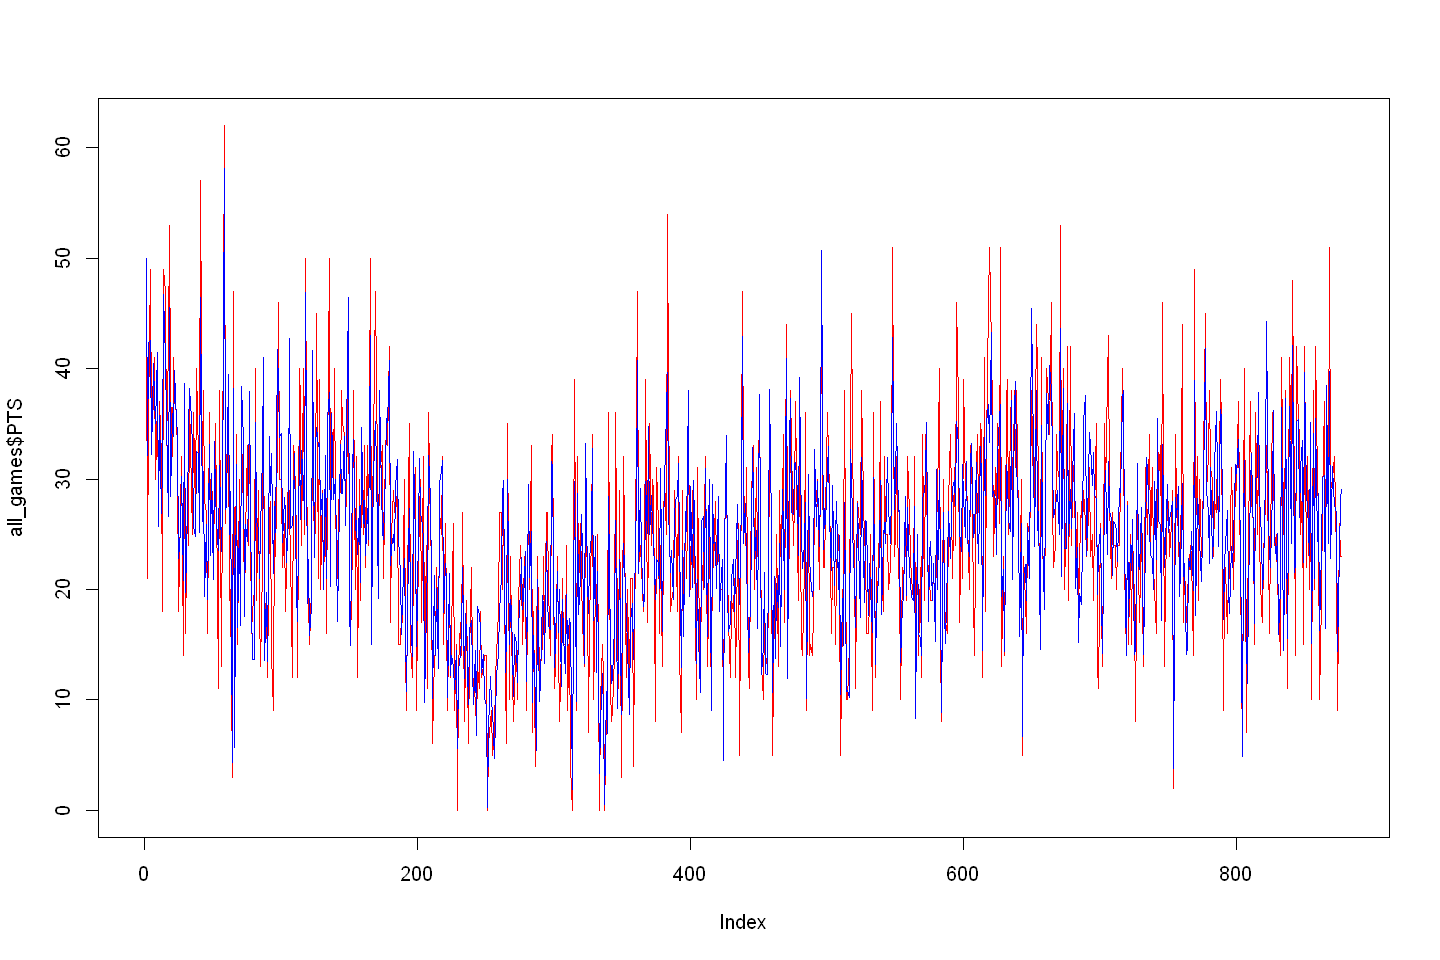

In [163]:
options(repr.plot.width=12 ,repr.plot.height=8)
plot(all_games$PTS, type='l', lty=1.8, col='red')
lines(pred, type='l', lty=1.8, col='blue')

### Future Game
Using Stephen Curry's averages this 2022 Season, we will predict how much points he will score next game.

In [188]:
avg <- dbGetQuery(con, 'SELECT AVG("MIN"), AVG("FGA"), AVG("FTA"), 
                        AVG("REB"), AVG("AST"), AVG("STL"), AVG("PTS") FROM season_2022')

In [191]:
colnames(avg) <- c('MIN', 'FGA', 'FTA', 'REB', 'AST', 'STL', 'PTS')
avg

MIN,FGA,FTA,REB,AST,STL,PTS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
34.88235,20.19608,5.058824,6.254902,6.352941,0.9607843,29.58824


In [192]:
next_game <- predict(model, avg)

In [203]:
cat("Stephen Curry will score", next_game,"points next game")

Stephen Curry will score 28.57386 points next game

In [ ]:
dbDisconnect(con)